# Whisper - Release In The Wild - Retreival Augmented Framework for Deepfake Audio Detection

## Whisper Model For Deepfake Audio Detection


### How Whisper Processes Audio

1. Convert Audio to Spectrogram: The raw audio waveform is first converted into a log-Mel spectrogram representation, which is a common format in speech and audio processing. This spectrogram captures frequency and time information while being computationally efficient.

2. Spectrogram Specifications: Whisper uses a specific configuration for generating the Mel spectrogram:
    * Sample Rate: 16,000 Hz (Whisper expects audio to be resampled to 16 kHz if not already).
    * Window Size: 25 ms (400 samples at 16 kHz).
    * Hop Length: 10 ms (160 samples at 16 kHz).
    * Number of Mel Filters: 80.
    
      
3. Log-Mel Spectrogram Processing: Once the Mel spectrogram is generated, it is converted to a logarithmic scale, creating a log-Mel spectrogram. This transformation helps model the human perception of sound, as perceived loudness is logarithmic.

## Training

In [4]:
import logging
from config import Config
from dataset import AudioDataset
import argparse
import os
from pipeline import DeepfakeDetectionPipeline
import torch

# ========================
# Main runner (same behavior; wandb toggle)
# ========================
"""
Run the complete audio deepfake detection pipeline with single-GPU optimizations.
"""
import argparse

# 1. Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# 3. Disable problematic torchaudio backends
os.environ["TORCHAUDIO_USE_SOX"] = "0"
os.environ["TORCHAUDIO_USE_BACKEND_DISPATCHER"] = "1"

# 4. Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.set_device(device)

# 5. Create configuration
config = Config()
config.device = device

config.train_split = 0.8
mode = "train"
audio_path = None
config.feature_extractor_type = "whisper"
pipeline_check = False

if pipeline_check:
  config.data_fraction = 0.01
  config.num_epochs = 2
  # 5a. Wandb toggle
  use_wandb = False  # set False to disable W&B
else:
  config.data_fraction = 1.0
  config.num_epochs = 10
  # 5a. Wandb toggle
  use_wandb = True  # set False to disable W&B


config.use_wandb = use_wandb

# 6. DataLoader settings
config.num_workers = max(1, torch.cuda.device_count() * 2)
config.train_batch_size = getattr(config, "train_batch_size", 256)
config.eval_batch_size = getattr(config, "eval_batch_size", 256)
config.db_batch_size = getattr(config, "db_batch_size", 64)
config.top_k = getattr(config, "top_k", 5)
config.use_batch_norm = False
config.use_layer_norm = True


# 7. Initialize pipeline
pipeline = DeepfakeDetectionPipeline(config)

if mode == "train":
    train_dataset = AudioDataset(config, is_train=True, split_data=True)
    val_dataset   = AudioDataset(config, is_train=False, split_data=True)
    pipeline.print_split_stats(train_dataset, "Train")
    pipeline.print_split_stats(val_dataset,   "Val")
    pipeline.train(train_dataset, val_dataset)

elif mode == "evaluate":
    config.use_wandb = False
    pipeline.load_models("final_model")
    pipeline.vector_db.load()

    test_dataset = AudioDataset(config, is_train=False, split_data=True)
    if hasattr(pipeline, "evaluate_with_metrics"):
        metrics = pipeline.evaluate_with_metrics(test_dataset)
        print("Evaluation metrics:")
        for key, value in metrics.items():
            print(f"{key}: {value}")
    else:
        loss, acc = pipeline.evaluate(test_dataset)
        print(f"Eval Loss: {loss:.4f}, Eval Acc: {acc:.4f}")

elif mode == "predict":
    if not audio_path:
        raise ValueError("Audio path must be provided for predict mode")
    pipeline.load_models("best_model")
    pipeline.vector_db.load()
    result = pipeline.predict(audio_path)
    logging.info(f"Prediction  : {result['prediction']}")
    logging.info(f"Probability(bona-fide) : {result['probability_bonafide']:.4f}")
    logging.info(f"Retrieved   : {result['retrieved_labels']}")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

Feature dimension set to: 512
Train set → total: 25423, bonafide: 9453 (37.18%), spoof: 15970 (62.82%)
Val set → total: 6356, bonafide: 2363 (37.18%), spoof: 3993 (62.82%)


Vector DB Build: 100%|██████████| 398/398 [37:06<00:00,  5.59s/it]
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: avinash-saxena (avinash-saxena-san-jose-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Evaluating: 100%|██████████| 25/25 [09:18<00:00, 22.33s/it]


Epoch 1: Train Loss: 0.8806, Train Acc: 0.5267, Val Loss: 0.8533, Val Acc:0.4437 | AUC: 0.7307, EER: 32.79% (thr=0.4121), Macro EER: 39.10%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [09:10<00:00, 22.02s/it]


Epoch 2: Train Loss: 0.8025, Train Acc: 0.6305, Val Loss: 0.7379, Val Acc:0.5642 | AUC: 0.8453, EER: 21.60% (thr=0.7847), Macro EER: 27.33%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [09:12<00:00, 22.10s/it]


Epoch 3: Train Loss: 0.5947, Train Acc: 0.7790, Val Loss: 0.5860, Val Acc:0.8296 | AUC: 0.9243, EER: 15.10% (thr=-1.4795), Macro EER: 16.37%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [09:11<00:00, 22.05s/it]


Epoch 4: Train Loss: 0.5884, Train Acc: 0.7890, Val Loss: 0.4902, Val Acc:0.7996 | AUC: 0.9336, EER: 14.21% (thr=1.0195), Macro EER: 14.49%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [09:08<00:00, 21.95s/it]


Epoch 5: Train Loss: 0.4901, Train Acc: 0.8294, Val Loss: 0.3799, Val Acc:0.8770 | AUC: 0.9465, EER: 12.62% (thr=-0.1362), Macro EER: 11.51%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [09:00<00:00, 21.61s/it]


Epoch 6: Train Loss: 0.4127, Train Acc: 0.8648, Val Loss: 0.5195, Val Acc:0.7749 | AUC: 0.9584, EER: 10.96% (thr=2.0234), Macro EER: 9.37%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [08:54<00:00, 21.37s/it]


Epoch 7: Train Loss: 0.4021, Train Acc: 0.8697, Val Loss: 0.3595, Val Acc:0.8650 | AUC: 0.9637, EER: 9.96% (thr=0.8027), Macro EER: 8.13%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [08:55<00:00, 21.43s/it]


Epoch 8: Train Loss: 0.3546, Train Acc: 0.8904, Val Loss: 0.3456, Val Acc:0.8661 | AUC: 0.9685, EER: 9.09% (thr=1.1953), Macro EER: 7.23%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [08:58<00:00, 21.54s/it]


Epoch 9: Train Loss: 0.3396, Train Acc: 0.8940, Val Loss: 0.3151, Val Acc:0.8916 | AUC: 0.9720, EER: 8.67% (thr=1.0801), Macro EER: 6.38%, min t-DCF: nan


Evaluating: 100%|██████████| 25/25 [08:57<00:00, 21.52s/it]


Epoch 10: Train Loss: 0.4128, Train Acc: 0.8585, Val Loss: 0.3183, Val Acc:0.9165 | AUC: 0.9734, EER: 8.38% (thr=-1.3008), Macro EER: 6.24%, min t-DCF: nan


curves/auc,▁▄▇▇▇█████
grad_norm/detection,▁▁▂▁▂▁▁▁▂▄▁▆▅▃▂▃▆▅▃▄▄▅▂▃▂▃▂▃▃▃▂▃▂▃▃▂▂▂█▅
grad_norm/fuse,▁▁▁▁▁▁▁▁▁▁▂▂▂▅▄▁▃▃▃▄▃▄▃▄▅▄▃▄▅▄▅▃▂▃▅▄▂█▄▅
grad_norm/projection,▁▁▁▁▁▂▄▂▂▃▅▆▃▅█▄▃▂▃▅▆▄▆▂▅▄▄▅▄▄▄▅▃▄█▃▄▅█▂
lr/detection,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/fuse,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/projection,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_loss,████▇▆▅▇▅▅▃▅▅▅▃▄▃▄▂▂▃▂▃▂▄▂▃▂▃▁▂▃▂▃▁▂▃▅▄▂
train/nnz_neighbor_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
curves/auc,0.97335
grad_norm/detection,1.50853


## Loss and Accuracy Curve

In [5]:
pipeline.plot_training_curves()

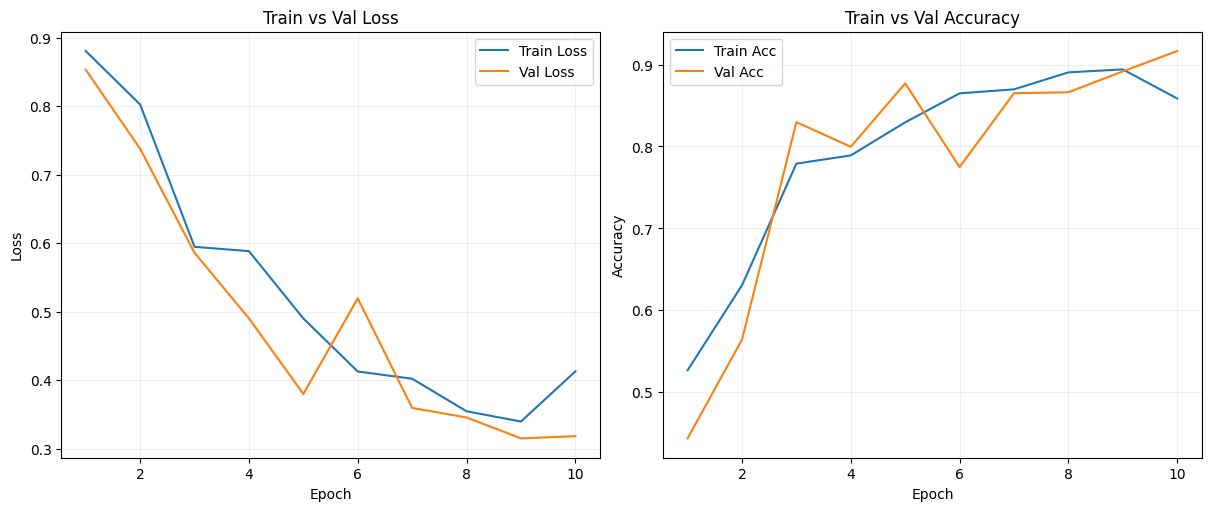

In [6]:
pipeline.show_curves_inline()

## Sample Predictions

### Spoof Prediction

In [8]:
import pandas as pd
file_name = "10136.wav"
audio_path = "/content/release_in_the_wild/"+file_name

df = pd.read_csv("/content/release_in_the_wild/meta.csv")
expected = df[df["file"]==file_name]


# 12. Single-file prediction on GPU
result = pipeline.predict(audio_path)

filtered_df = df[df["file"].isin(result['retrieved_files'])]


print(f"Prediction  : {result['prediction']}, Expected: {expected['label'].values[0]}, Speaker: {expected['speaker'].values[0]}")
print(f"Probability Spoof: {result['probability_spoof']:.4f}")
print("Similar Audio Files retrieved")
print(filtered_df)

Prediction  : spoof, Expected: spoof, Speaker: Alec Guinness
Probability Spoof: 0.9682
Similar Audio Files retrieved
            file         speaker  label
11028  11028.wav   Alec Guinness  spoof
14695  14695.wav  Bernie Sanders  spoof
18917  18917.wav   Alec Guinness  spoof
21254  21254.wav   Alec Guinness  spoof
31126  31126.wav             FDR  spoof


### Bonafide Prediction

In [9]:
file_name = "10135.wav"
audio_path = "/content/release_in_the_wild/"+file_name

df = pd.read_csv("/content/release_in_the_wild/meta.csv")
expected = df[df["file"]==file_name]


# 12. Single-file prediction on GPU
result = pipeline.predict(audio_path)

filtered_df = df[df["file"].isin(result['retrieved_files'])]


print(f"Prediction  : {result['prediction']}, Expected: {expected['label'].values[0]}, Speaker: {expected['speaker'].values[0]}")
print(f"Probability Spoof: {result['probability_spoof']:.4f}")
print("Similar Audio Files retrieved")
print(filtered_df)

Prediction  : bona-fide, Expected: bona-fide, Speaker: Barack Obama
Probability Spoof: 0.0275
Similar Audio Files retrieved
            file         speaker      label
6102    6102.wav  George W. Bush  bona-fide
6553    6553.wav    Barack Obama  bona-fide
13310  13310.wav    Barack Obama  bona-fide
17510  17510.wav    Barack Obama  bona-fide
31160  31160.wav    Barack Obama  bona-fide
